# NEURAL NETWORKS AND DEEP LEARNING PROJECT

---
A.A. 2023/24 (6 CFU) - Giuseppe Labate, Sana Amiri
---

## Project 1 - Car classification, attribute prediction and car verification

In this project 

1.   **Classification** car images given cars dataset CompCars.

2.   **Attributes prediction** based on the images.  
        Attributes for this project are:  
    1. Explicit Attributes:  
    	1. Number of doors  
    	2. Number of seats  
    	3. Type of car  
	2. Implicit Attributes:  
    	4. Max speed  
    	5. Displacement  


In [1]:
## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
# %matplotlib inline
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')  # For export
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
# sns.set()  ---> Uncomment if you want to use seaborn themes

## tqdm for loading bars
from tqdm.notebook import tqdm
import os
import random
## NumPy
import numpy as np
## PyTorch
import torch
import torch.nn as nnpo
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

import scipy.io
import time
from torch.autograd import Variable

## Torchvision
import torchvision   # For Computer Vision tasks
from torchvision import transforms   # Transforms for images for data augmentation


# Path to the folder where the datasets are/should be downloaded
DATA_PATH = os.path.join(".", "Deep_Project", "data")  # Change this path to your desired location

NUM_WORKERS = 0 #os.cpu_count()

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Device: cuda:0
Number of workers: 0


<Figure size 640x480 with 0 Axes>

In the following cell, I will create a transformation composition that will be applied to the images in our dataset. This transformation is crucial for preprocessing the images before they are fed into our machine learning model. The preprocessing steps may include operations such as resizing, normalization, augmentation, and other techniques to enhance the quality and variability of the training data. By applying these transformations, we aim to improve the model's performance and generalization capabilities. Let's proceed with defining this transformation function in the next cell.

In [2]:
transform = transforms.Compose([
	transforms.Resize((224, 224)),
	transforms.ToTensor(),
	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# transform = transforms.Compose([
# 	transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input size
# 	transforms.ToTensor(),
# 	transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
# ])

In the next code snippet, we will perform DataLoading of the dataset contained in `./Deep_Project/data`. The dataset will be split according to the splitting files located in the `train_test_split` folder.

FROM HERE THE CODE IS USED TO CROP THE DATASET AND LOAD IT CORRECTLY WITH THE RIGHT LABEL


In [3]:
####MODIFICA ALLA FUNZIONE SAVE_CROP_IMAGES###
#HERE THE FUNCTION HAS TO SAVE THE IMAGES IN THE FOLDER CROPPED_IMAGES/DIRECTORY OF THE FULL IMAGE
#FOR EXAMPLE, IF THE FULL IMAGE IS IN THE FOLDER "image/AM General Hummer SUV 2000" THE CROPPED IMAGE HAS TO BE SAVED IN "cropped_images/classification/train/AM General Hummer SUV 2000"
#WE WANT ALSO TO DO IT WITHOUT USING CROPDATASET FUNCTION

from PIL import Image
import torchvision.transforms as transforms

# Path to the folder where the datasets are/should be downloaded
image_dir = os.path.join(DATA_PATH, "image")
label_dir = os.path.join(DATA_PATH, "label")
train_list = os.path.join(DATA_PATH, "train_test_split", "classification", "train.txt")
test_list = os.path.join(DATA_PATH, "train_test_split", "classification", "test.txt")

def crop_image(image, bbox):
	x1, y1, x2, y2 = bbox
	image_np = np.array(image)
	return image_np[y1:y2, x1:x2]

#Loads the viewpoint and bounding box from the label file
def load_label(label_path):
	with open(label_path, 'r') as f:
		lines = f.readlines()
		viewpoint = int(lines[0].strip())
		bbox = list(map(int, lines[2].strip().split()))
	return viewpoint, bbox

def save_cropped_images(file_list, output_dir):
	# Create the output directory if it does not exist
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)

		# Access to the image paths and labels
		with open(file_list, 'r') as f:
			for line in tqdm(f, desc="Saving images"):
				image_path = os.path.join(image_dir, line.strip())
				label_path = os.path.join(label_dir, line.strip()).replace('.jpg', '.txt')
				car_properties = load_label(label_path)
				# Dividing the label path into car make, model and year
				label_path_parts = line.strip().split('/')

				# Given the values of labels path, put the correct car make, model and year in the output directory
				output_image_dir = os.path.join(output_dir, label_path_parts[0], label_path_parts[1], label_path_parts[2])
				os.makedirs(output_image_dir, exist_ok=True)

				# Load the image
				image = Image.open(image_path).convert("RGB")

				# Crop the image
				cropped_image = crop_image(image, car_properties[1])
				cropped_image = transforms.ToPILImage()(cropped_image)

				# Save the cropped image
				output_image_path = os.path.join(output_image_dir, os.path.basename(image_path))
				cropped_image.save(output_image_path)

def get_names(mat_file, labels):
	# Load the make and model names from the .mat file
	mat_data = scipy.io.loadmat(mat_file)
	make_names = mat_data['make_names']
	model_names = mat_data['model_names']
	make_name = make_names[int(labels[0]) - 1][0].item()
	model_name = model_names[int(labels[1]) - 1][0].item()
	return make_name, model_name

# Example usage
output_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_path = os.path.join(output_dir, "train")

test_path = os.path.join(output_dir, "test")
print("test", test_path)
print("train", train_path)
save_cropped_images(train_list, train_path)
save_cropped_images(test_list, test_path)


test .\Deep_Project\data\cropped_image\classification\test
train .\Deep_Project\data\cropped_image\classification\train


In [4]:
#### DATA LOADER FOR CROPPED IMAGES ####
from torch.utils.data import Dataset, DataLoader

class CroppedCarDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform

		# Save the images contained in image_dir
        self.image_paths = []
        for root, _, files in os.walk(image_dir):
            for file in files:
                if file.endswith(".jpg"):
                    self.image_paths.append(os.path.join(root, file))

		# Save the labels
        self.car_make = []
        self.car_model = []
        for image_path in self.image_paths:
            label = image_path.split(os.sep)[-4:-1]  # Car make, model, year
            #Get labels from the image path, append them to the lists, and convert them to tensors of type long
            self.car_make.append(int(label[0]))
            self.car_model.append(int(label[1]))

		# # Load the make and model names from the .mat file
        # mat_data = scipy.io.loadmat(mat_file)
        # self.make_names = mat_data['make_names']
        # self.model_names = mat_data['model_names']

	#Returns the image, viewpoint, bounding box and label path
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")

        # make_name = self.make_names[int(labels[0]) - 1][0].item()
        # model_name = self.model_names[int(labels[1]) - 1][0].item()
        # year = labels[2]

        #label = [make_name, model_name, year]
        car_make = self.car_make[index]
        car_model = self.car_model[index]

        if self.transform:
            image = self.transform(image)

        return image, car_make, car_model

    def __len__(self):
        return len(self.image_paths)

print("Data loading is complete.")



Data loading is complete.


In [5]:
# Path to the folder where the datasets are/should be downloaded
class_dir = os.path.join(DATA_PATH, "cropped_image", "classification")
train_dir = os.path.join(class_dir, "train")
test_dir = os.path.join(class_dir, "test")
mat_file = os.path.join(DATA_PATH, "misc" ,"make_model_name.mat")

# Create the datasets
train_val_dataset = CroppedCarDataset(image_dir=train_dir, transform=transform) #dataset that contains train and validation datasets

train_len = int(0.7*len(train_val_dataset))  # 70% training
val_len = len(train_val_dataset) - train_len	# 30% validation

train_dataset, val_dataset = data.random_split(train_val_dataset, [train_len, val_len])

test_dataset = CroppedCarDataset(image_dir=test_dir, transform=transform)   #dataset that contains test dataset



# Create the data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=NUM_WORKERS)

Dataset labels: {'Audi': 626, 'MAZDA': 299, 'Changan': 212, 'Benz': 443, 'Cadillac': 146, 'Toyota': 408, 'Haima': 146, 'Citroen': 256, 'BWM': 584, 'Wuling': 57, 'KIA': 339, 'Ford': 281, 'Hyundai ': 273, 'Suzuki': 210, 'Roewe': 110, 'Peugeot': 340, 'Lexus': 249, 'LAND-ROVER': 172, 'Porsche': 148, 'Volkswagen': 844, 'Jianghuai': 177, 'Besturn': 129, 'FIAT': 91, 'Buck': 335, 'Haval': 50, 'Dongfengfengshen': 85, 'Geely': 136, 'Volvo': 410, 'Chevy': 361, 'GreatWall': 148, 'Guangqichuanqi': 27, 'Honda': 185, 'Chrey': 210, 'MINI': 168, 'Yiqi': 61, 'Nissan': 300, 'MG': 115, 'Zxauto': 44, 'Baojun': 93, 'Lifan': 45, 'Zhonghua': 159, 'Dongfengfengxing': 37, 'Infiniti': 165, 'Jeep': 145, 'DS': 76, 'Jaguar': 89, 'Mitsubishi': 202, 'Qoros': 16, 'BAW': 36, 'Opel': 58, 'Renault': 80, 'Skoda': 205, 'Chrysler': 36, 'BYD': 166, 'Lamorghini ': 50, 'Subaru': 42, 'Dongfengfengdu': 26, 'smart': 60, 'Ruiqi': 18, 'Shangqidatong': 13, 'Lufeng': 37, 'Zoyte': 15, 'Everus': 14, 'Venucia': 34, 'Shuanglong': 11, 'Jo

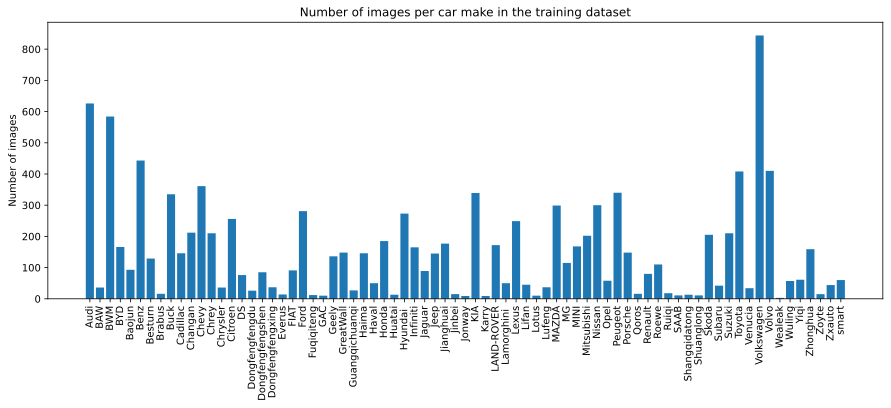

Dataset labels: {'Roewe': 58, 'Toyota': 184, 'Audi': 311, 'Skoda': 94, 'Nissan': 131, 'MG': 46, 'Jianghuai': 76, 'Hyundai ': 87, 'Jeep': 56, 'Wuling': 19, 'Citroen': 104, 'Volvo': 177, 'Mitsubishi': 94, 'Ford': 100, 'Opel': 26, 'Cadillac': 80, 'Volkswagen': 357, 'MAZDA': 108, 'Peugeot': 150, 'Buck': 130, 'GreatWall': 60, 'Renault': 40, 'Besturn': 66, 'LAND-ROVER': 69, 'Lexus': 101, 'Benz': 200, 'Chevy': 137, 'FIAT': 29, 'KIA': 130, 'Haima': 62, 'BYD': 60, 'Guangqichuanqi': 7, 'Zhonghua': 89, 'Honda': 103, 'Suzuki': 78, 'DS': 42, 'BWM': 261, 'Yiqi': 31, 'Dongfengfengxing': 12, 'Changan': 87, 'Porsche': 76, 'MINI': 68, 'Infiniti': 63, 'Qoros': 4, 'Baojun': 34, 'GAC': 3, 'BAW': 8, 'Lifan': 24, 'Jaguar': 44, 'Everus': 8, 'Dongfengfengshen': 50, 'Geely': 63, 'smart': 23, 'Wealeak': 7, 'Chrey': 109, 'Jinbei': 7, 'Fuqiqiteng': 4, 'Haval': 21, 'Lufeng': 10, 'Dongfengfengdu': 10, 'Chrysler': 11, 'Lotus': 7, 'Ruiqi': 12, 'Karry': 4, 'Shuanglong': 3, 'Brabus': 6, 'Lamorghini ': 10, 'Zoyte': 4, 'H

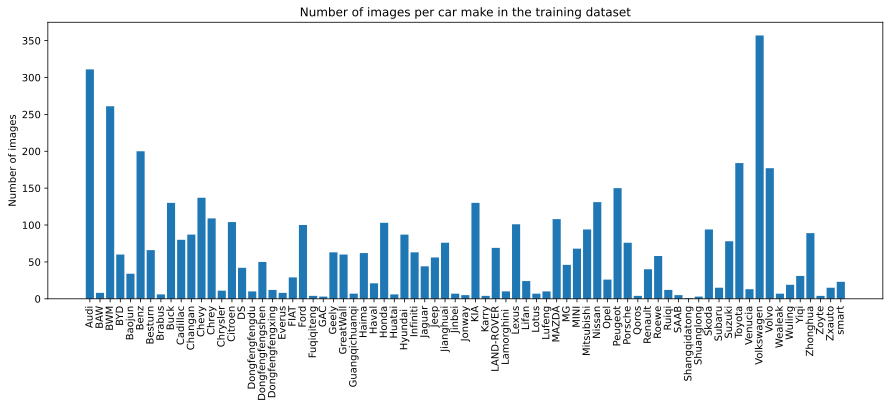

Dataset labels: {'Honda': 270, 'Peugeot': 450, 'Opel': 80, 'BYD': 210, 'Jonway': 9, 'Jianghuai': 240, 'Jeep': 193, 'Volvo': 558, 'Haima': 190, 'Hyundai ': 326, 'Everus': 21, 'Ruiqi': 27, 'Fuqiqiteng': 14, 'Ford': 360, 'SAAB': 14, 'Infiniti': 214, 'Roewe': 160, 'Lotus': 13, 'FIAT': 106, 'Qoros': 16, 'MG': 149, 'KIA': 431, 'LAND-ROVER': 226, 'Jinbei': 21, 'Suzuki': 270, 'MINI': 225, 'GreatWall': 191, 'Changan': 267, 'Lufeng': 42, 'Chevy': 471, 'Citroen': 345, 'Lexus': 322, 'Renault': 110, 'MAZDA': 376, 'smart': 80, 'Yiqi': 82, 'Mitsubishi': 278, 'Shangqidatong': 12, 'Dongfengfengdu': 33, 'Dongfengfengshen': 122, 'Dongfengfengxing': 42, 'Zxauto': 54, 'Zhonghua': 225, 'Toyota': 548, 'DS': 108, 'Wuling': 70, 'Zoyte': 17, 'Porsche': 212, 'Chrysler': 43, 'Lamorghini ': 57, 'Cadillac': 213, 'Buck': 438, 'Lifan': 63, 'BAW': 41, 'Huatai': 15, 'Shuanglong': 11, 'Geely': 182, 'Venucia': 44, 'Haval': 69, 'Volkswagen': 1125, 'Chrey': 283, 'Besturn': 186, 'Benz': 614, 'Audi': 891, 'Wealeak': 10, 'BWM

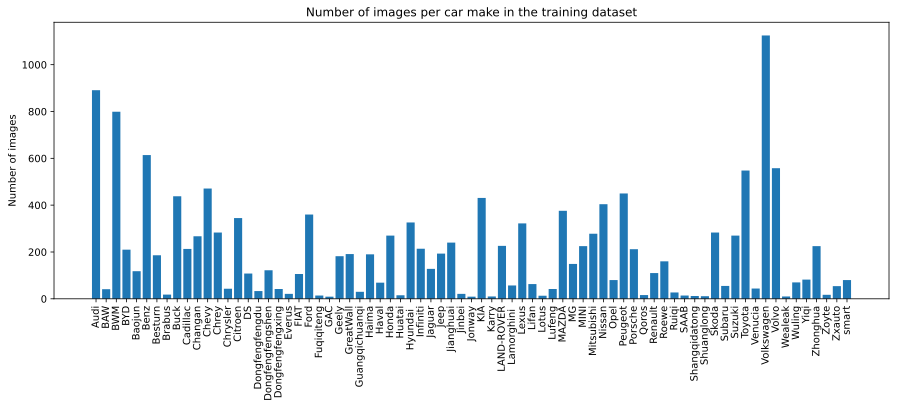

In [6]:
############################################################
# Function to count the number of images per car make
############################################################

from collections import Counter
def count_labels(dataset, make = True):
	# Extracts the labels from the dataset
	if make:
		list = [make for _, make, _ in dataset]
	else:
		list = [model for _, _, model in dataset]

	# Counts the occurrences of each label
	dataset_count = Counter(list)

	# Transform the labels into the string using get_names function
	if make:
		dataset_count_strings = {tuple(get_names(mat_file, [label, 0]))[0]: count for label, count in dataset_count.items()}
	else:
		dataset_count_strings = {tuple(get_names(mat_file, [0, label]))[1]: count for label, count in dataset_count.items()}

	# Print the labels and their counts
	print("Dataset labels:", dataset_count_strings)

	# Sort the labels by alphabetical order
	sorted_labels = sorted(dataset_count_strings.items(), key=lambda x: x[0])
	labels, counts = zip(*sorted_labels)

	# Create the plot
	plt.figure(figsize=(15, 5))
	plt.bar(labels, counts)
	plt.xticks(rotation=90)
	plt.ylabel("Number of images")
	plt.title("Number of images per car make in the training dataset")
	plt.show()

	return dataset_count_strings



train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

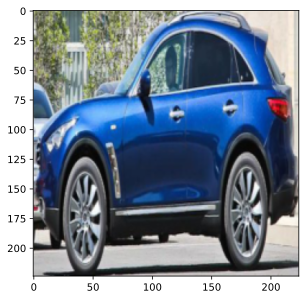

Make: 131
Model: 1015
0
torch.Size([32, 3, 224, 224])
tensor([150, 118, 162, 102,  81, 102, 149,  73,  78,  81, 140, 102,  78,  54,
         54, 142,  11, 118, 111,  58,  78, 149, 142,  39, 114,  73, 122, 108,
        142, 140,  27,  54])
tensor([ 392,  976, 1631,  263,  103,  254, 1793,  441,    1,   70, 1180,  256,
          22,  191,  190, 1138,  736,  955, 1721,  342,   27, 1793, 1134, 1333,
        1443,  467,  597, 1526, 1135, 1188, 1070,  188])
('Infiniti', 'Infiniti QX70')
Number of images in the training set: 11211
Number of images in the validation set: 4805
Number of images in the test set: 14939
Image shape: torch.Size([3, 224, 224])


In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Function to denormalize images
def denormalize(img, mean, std):
    img = img.clone()  # Create a copy of the image
    for t, m, s in zip(img, mean, std):
        t.mul_(s).add_(m)  # Denormalize
    return img

# Function to display images
def imshow(img):
    #img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Mean and std used for normalization
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Display the first 5 images from the training set
# for i in range(5):
#     img, label = train_dataset[i]
#     img = denormalize(img, mean, std)
#     imshow(img)
#     print("Labels:",label)

img, car_make, car_model = val_dataset[2000]
img = denormalize(img, mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)


for i, (img_batch, car_make_batch, car_model_batch) in enumerate(train_loader):
	print(i)
	print(img_batch.shape)
	print(car_make_batch)
	print(car_model_batch)
	break

print(get_names(mat_file, [car_make, car_model]))


print("Number of images in the training set:", len(train_dataset))
print("Number of images in the validation set:", len(val_dataset))
print("Number of images in the test set:", len(test_dataset))
print("Image shape:", img.shape)

# Model

Let's create the models we will use.  
In this project we will train and test 3 different models to see which one is better:  
##### 1. ImageNet pretrained Network
##### 2. ResNet50
##### 3. Inception v4

In [8]:
# #HERE I TRY USING THE GITHUB LINK TECHNIQUE
# from torchvision.models import Inception_V3_Weights
# # Load the model
# net = torchvision.models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)

# # Change the number of output features
# MODELS_NUM = 431
# MAKE_NUM = 163

# num_features = net.fc.in_features
# net.fc = nnpo.Linear(num_features, MAKE_NUM)

# if torch.cuda.device_count() > 1:
#     net = torch.nn.DataParallel(net)

# net.cuda()

# criterion = torch.nn.CrossEntropyLoss()
# criterion.cuda()

# optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
# my_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
# dloaders = {'train': train_loader, 'valid': val_loader}



In [9]:
# from torch.utils.tensorboard import SummaryWriter


# def train_model(dataloders, model, criterion, optimizer, scheduler, num_epochs=10000):
#     logger = SummaryWriter()
#     since = time.time()
#     best_acc = 0.0
#     dataset_sizes = {'train': len(dataloders['train'].dataset),
#                      'valid': len(dataloders['valid'].dataset)}
#     print("train and valid sizes %d %d" % (len(dataloders['train'].dataset), len(dataloders['valid'].dataset)))

#     for epoch in range(num_epochs):
#         epoc_time = time.time()
#         print(f'Epoch {epoch}/{num_epochs - 1}')
#         print('-' * 10)

#         for phase in ['train', 'valid']:
#             if phase == 'train':
#                 scheduler.step()
#                 model.train()
#             else:
#                 model.eval()

#             running_loss = 0.0

#             if phase == 'train':
#                 train_running_corrects = 0
#             else:
#                 valid_running_corrects = 0

#             # Use tqdm to create a progress bar
#             with tqdm(total=len(dataloders[phase]), desc=f'{phase} Epoch {epoch + 1}/{num_epochs}', unit='batch') as pbar:
#                 for inputs, label_make, label_model in dataloders[phase]:
#                     t1 = time.time()
#                     labels = label_make
#                     inputs, labels = inputs.cuda(), labels.cuda()

#                     optimizer.zero_grad()

#                     t2 = time.time()
#                     outputs = model(inputs)
#                     t3 = time.time()

#                     if phase == 'train':
#                         loss1 = criterion(outputs[0], labels)
#                         loss2 = criterion(outputs[1], labels)
#                         loss = loss1 + loss2  # Future work, change to e.g. loss1 + 0.4 x loss2
#                         preds = torch.max(outputs[0], 1)[1]
#                         train_running_corrects += torch.sum(preds == labels.data)
#                     else:
#                         loss = criterion(outputs, labels)
#                         _, preds = torch.max(outputs.data, 1)
#                         valid_running_corrects += torch.sum(preds == labels.data)

#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()
#                     t4 = time.time()

#                     running_loss += loss.item()
#                     pbar.update(1)  # Update the progress bar

#             if phase == 'train':
#                 train_epoch_loss = running_loss / dataset_sizes[phase]
#                 train_epoch_acc = train_running_corrects.double() / dataset_sizes[phase] * 100
#             else:
#                 valid_epoch_loss = running_loss / dataset_sizes[phase]
#                 valid_epoch_acc = valid_running_corrects.double() / dataset_sizes[phase] * 100

#             if phase == 'valid' and valid_epoch_acc > best_acc:
#                 best_acc = valid_epoch_acc
#                 best_model_wts = model.state_dict()
#                 torch.save({
#                     'epoch': epoch,
#                     'epochTrainLoss': train_epoch_loss,
#                     'epochValidLoss': valid_epoch_loss,
#                     'epochTrainAcc': train_epoch_acc,
#                     'epochValidAcc': valid_epoch_acc,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                 }, os.path.join(DATA_PATH, "Inception_classification.pth"))

#         epocTotalTime = time.time() - epoc_time
#         epocLoadDataTime = t2 - t1
#         epocForwardTime = t3 - t2
#         epocLossBackwardTime = t4 - t3
#         print('Epoch [{}/{}] train loss: {:.4f} acc: {:.4f}% '
#               'valid loss: {:.4f} acc: {:.4f}% Time: {:.0f}s train corr: {:d}  valid corr: {:d}  '.format(
#                 epoch, num_epochs - 1,
#                 train_epoch_loss, train_epoch_acc,
#                 valid_epoch_loss, valid_epoch_acc,
#                 (time.time() - epoc_time),
#                 train_running_corrects,
#                 valid_running_corrects
#               ))
#         logger.add_scalar('Train/epocLoss', train_epoch_loss, epoch)
#         logger.add_scalar('Train/accuracy', train_epoch_acc, epoch)
#         logger.add_scalar('Valid/epocLoss', valid_epoch_loss, epoch)
#         logger.add_scalar('Valid/accuracy', valid_epoch_acc, epoch)
#         logger.add_scalar('Train/epocTotalTime', epocTotalTime, epoch)
#         logger.add_scalar('Train/epocLoadDataTime', epocLoadDataTime, epoch)
#         logger.add_scalar('Train/epocForwardTime', epocForwardTime, epoch)
#         logger.add_scalar('Train/epocLossBackward', epocLossBackwardTime, epoch)

#     print('Best val Acc: {:4f}'.format(best_acc))
#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     return model

In [10]:
# num_epoches = 10000
# start_time = time.time()

# model = train_model(dloaders, net, criterion, optimizer, my_scheduler, num_epochs=num_epoches)
# print('Training time: {:10f} minutes'.format((time.time()-start_time)/60))

In [11]:
# toy exemple to understand the cross entropy loss

import torch
import torch.nn as nn

# Supponiamo di avere un batch di dimensione 3 e 5 classi
logits = torch.tensor([[0.0, 2.0, 0.0, 4.0, 1.0],
                       [1.0, 0.0, 0.0, 1.0, 4.0],
                       [4.0, 1.0, 2.0, 0.0, 1.0]], requires_grad=True)

# Etichette di classe vere per ciascun esempio nel batch
labels = torch.tensor([3, 4, 0])

# Definisci la funzione di perdita
criterion = nn.CrossEntropyLoss()

# Calcola la perdita
loss = criterion(logits, labels)

print(loss)

tensor(0.1846, grad_fn=<NllLossBackward0>)


In [ ]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

MODELS_NUM = 431
MAKE_NUM = 163
checkpoint_path = os.path.join(DATA_PATH, "checkpoint.pth.tar")

car_make_bool = True   ## TODO Remove this line

# Upload a pre-trained model to ImageNet
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# # Freeze all the layers in the network
# for param in model.parameters():
# 	param.requires_grad = False

# Get the number of features in the model
num_features = model.fc.in_features
print("Number of features:", num_features)
# Replace the final layer with a fully connected layer with the number of features in the model
if car_make_bool:
	model.fc = nnpo.Linear(num_features, MAKE_NUM)
else:
	model.fc = nnpo.Linear(num_features, MODELS_NUM)

# Move the model to the device
model = model.to(device)

# Define the loss function
criterion = nnpo.CrossEntropyLoss()
criterion = criterion.to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Function to save the checkpoint
def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)

# Function to load the checkpoint
def load_checkpoint(model, optimizer, scheduler, filename='checkpoint.pth.tar'):
    if os.path.isfile(filename):
        print(f"Loading checkpoint '{filename}'")
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        epoch = checkpoint['epoch']
        best_acc = checkpoint['best_acc']
        print(f"Loaded checkpoint '{filename}' (epoch {epoch})")
        return model, optimizer, scheduler, epoch, best_acc
    else:
        print(f"No checkpoint found at '{filename}'")
        return model, optimizer, scheduler, 0, 0.0

# Load the checkpoint
model, optimizer, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
print("Starting epoch:", start_epoch)

# Function to calculate the accuracy of the model
def accuracy(outputs, labels):
	_, preds = torch.max(outputs, dim=1)   # Get the prediction label for the batch
	return torch.tensor(torch.sum(preds == labels).item() / len(preds))  #sees how many predictions are correct in the batch

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, start_epoch=0, best_acc=0.0):
    best_model_wts = None

    for epoch in range(start_epoch, start_epoch + num_epochs):
        print('Epoch {}/{}'.format(epoch, start_epoch + num_epochs - 1))
        print('-' * 10)
        # if epoch > 20:
        #     # Unfreeze the layers after 20 epochs
        #     for param in model.parameters():
        #         param.requires_grad = True

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            iterator = tqdm(dataloader, desc=phase)
            for batch_x, batch_car_make, batch_car_model in iterator:
                batch_x = batch_x.to(device)
                if car_make_bool:
                    labels = batch_car_make.to(device)
                else:
                    labels = batch_car_model.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(batch_x)   # batch size x num_classes
                    loss = criterion(outputs, labels)

                    # Backward pass + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * batch_x.size(0)  #type float like loss.detach().cpu().numpy()
                running_corrects += accuracy(outputs, labels)

            if phase == 'train':
                train_loss = running_loss / len(train_dataset)
                train_acc = running_corrects.double() / len(train_dataset)
            else:
                val_loss = running_loss / len(val_dataset)
                val_acc = running_corrects.double() / len(val_dataset)

                # Update the learning rate
                scheduler.step()

                # Save the best model
                if val_acc > best_acc:
                    best_acc = val_acc
                    best_model_wts = model.state_dict()
                    # Save the model only if it is the best model
                    save_checkpoint({
                        'epoch': epoch,
                        'model_state_dict': model.state_dict(),
                        'best_model_wts': best_model_wts,
                        'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(),
                        'best_acc': best_acc,
                        'train_loss': train_loss,
                        'val_loss': val_loss,
                        'train_acc': train_acc,
                        'val_acc': val_acc,
                    }, checkpoint_path)
                    print("Model saved")

            print(f'{phase} Loss: {train_loss if phase == "train" else val_loss:.4f} Acc: {train_acc if phase == "train" else val_acc:.4f}')

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load the best model weights
    model, optimizer, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)

    return model

# Chiama la funzione di addestramento
model = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=80, start_epoch=start_epoch, best_acc=best_acc)

# Function to evaluate the model
def evaluate_model(model, dataloader):
	model.eval()
	running_loss = 0.0
	running_corrects = 0

	iterator = tqdm(dataloader, desc="Evaluation")
	# Iterate over data
	for batch_x, batch_car_make, batch_car_model in iterator:
		batch_x = batch_x.to(device)
		if car_make_bool:
			labels = batch_car_make.to(device)
		else:
			labels = batch_car_model.to(device)

		# Forward pass
		with torch.no_grad():
			outputs = model(batch_x)
			loss = criterion(outputs, labels)

		# Statistics
	running_loss += loss.item() * batch_x.size(0)
	running_corrects += accuracy(outputs, labels)

	epoch_loss = running_loss / len(dataloader.dataset)
	epoch_acc = running_corrects.double() / len(dataloader.dataset)

	print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))

# Evaluate the model on the test set
evaluate_model(model, test_loader)

# Function to predict the class of an image
def predict_image(image_path, model, transform):
	image = Image.open(image_path).convert("RGB")
	image = transform(image).unsqueeze(0).to(device)
	outputs = model(image)
	_, preds = torch.max(outputs, 1)
	return preds.item()

# Load the model
model, optimizer, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
model.eval()

# Predict the class of an image
image_path = os.path.join(test_dir, )

# Load the image
img, car_make, car_model = val_dataset[2000]
img = denormalize(img, mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
pred = model(img.unsqueeze(0).to(device)).argmax().item()
print("Prediction:", pred)




Number of features: 2048
Loading checkpoint '.\Deep_Project\data\checkpoint.pth.tar'
Loaded checkpoint '.\Deep_Project\data\checkpoint.pth.tar' (epoch 19)
Starting epoch: 19
Epoch 19/98
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

train Loss: 0.2306 Acc: 0.0303


val:   0%|          | 0/151 [00:00<?, ?it/s]

val Loss: 2.5221 Acc: 0.0136

Epoch 20/98
----------


train:   0%|          | 0/351 [00:00<?, ?it/s]

Loading checkpoint '.\Deep_Project\data\checkpoint.pth.tar'


C:\Users\giuse\AppData\Local\Temp\ipykernel_42196\3225665168.py:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Loaded checkpoint '.\Deep_Project\data\checkpoint.pth.tar' (epoch 19)


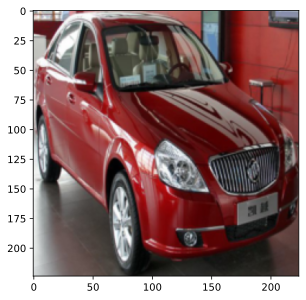

Make: 54
Model: 194
('Buck', 'Exclle')
Prediction: 132 ('Roewe', 'Noble M12')


In [13]:
###############################
# load previous save model
###############################

# Load the model
model, optimizer, scheduler, start_epoch, best_acc = load_checkpoint(model, optimizer, scheduler, checkpoint_path)
model.eval()

# Predict the class of an image
image_path = os.path.join(test_dir, )

# Load the image
random_number = random.randint(0, len(train_dataset))
img, car_make, car_model = train_dataset[random_number]
img = denormalize(img, mean, std)
imshow(img)
print("Make:",car_make)
print("Model:",car_model)

print(get_names(mat_file, [car_make, car_model]))

# Predict the class of the image
pred = model(img.unsqueeze(0).to(device)).argmax().item()
print("Prediction:", pred, get_names(mat_file, [pred, 0]))
